In [1]:
from backtest import do_simulation, daily_potential_pnl
from services.alpaca import AlpacaAssetDataService, AlpacaOptionsDataService
from strategies import *

In [2]:
asset_data_service = AlpacaAssetDataService()
options_data_service = AlpacaOptionsDataService()
asset = "SPY"

## Some potential P&L analysis based on daily position movement

In [3]:
# 1. either fetch anew:

# daily_movements = daily_potential_pnl(
#     datetime(2024, 2, 5),
#     datetime(2025, 2, 3),
#     asset,
#     asset_data_service,
#     options_data_service,
#     opening_strategy_iron_condor_specific_minute_idx(2),
# )

# # remove nan values
# daily_movements = [
#     movement 
#     for movement in daily_movements 
#     if np.isnan(movement).all() == False
# ]

# import json
# with open("daily_movements_open2.json", "w") as f:
#     json.dump([m.tolist() for m in daily_movements], f)


# 2. or load from file:

import json

with open("daily_movements_open2.json", "r") as f:
    daily_movements = json.load(f)
    daily_movements = [np.array(l) for l in daily_movements]

In [4]:
len(daily_movements)

247

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import ipywidgets as widgets

IntSlider(value=400, continuous_update=False, description='Profit Limit ($):', max=2000, min=50, readout_forma…

IntSlider(value=-400, continuous_update=False, description='Stop Loss ($):', max=-50, min=-5000, readout_forma…

IntSlider(value=0, continuous_update=False, description='Wait before stop loss (minutes):', max=400, style=Sli…

IntSlider(value=350, continuous_update=False, description='Dont close after n-th minute:', max=400, style=Slid…

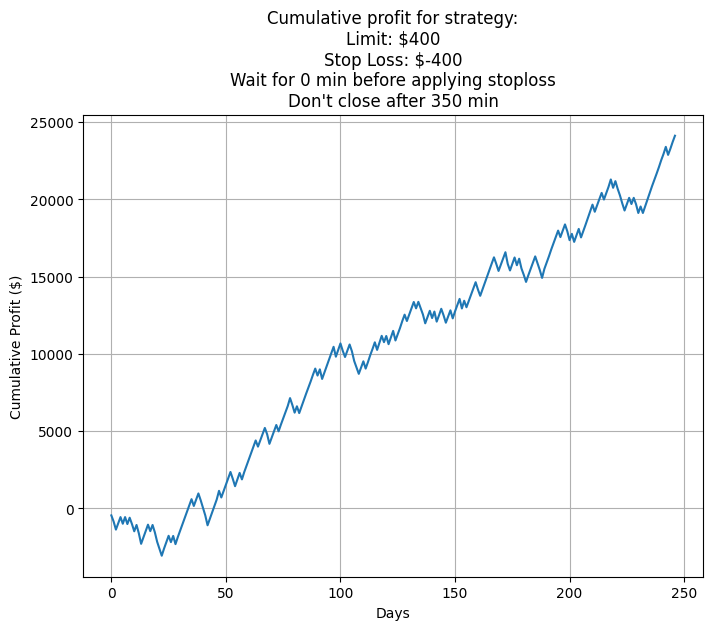

In [53]:
%matplotlib inline

limit_slider = widgets.IntSlider(
    value=400,  # default value
    min=50,
    max=2000,
    step=50,    # step size
    description='Profit Limit ($):',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    style={'description_width': 'initial'}
)

stoploss_slider = widgets.IntSlider(
    value=-400,  # default value
    min=-5000,
    max=-50,
    step=50,    # step size
    description='Stop Loss ($):',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
    style={'description_width': 'initial'}
)

wait_before_stoploss_slider = widgets.IntSlider(
    value=0,  # default value
    min=0,
    max=400,
    step=1,    # step size
    description='Wait before stop loss (minutes):',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style={'description_width': 'initial'}
)

close_nth_minute_slider = widgets.IntSlider(
    value=350,  # default value
    min=0,
    max=400,
    step=1,    # step size
    description='Dont close after n-th minute:',
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    style={'description_width': 'initial'}
)

def update_plot(profit_limit, stoploss, wait_before_stoploss, max_closing_minute):
    pnl = np.array([
        closing_strategy_limit_or_stoploss_after_n_ormth_minute(
            profit_limit,
            stoploss,
            wait_before_stoploss,
            max_closing_minute
        )(daily_movement)
        for daily_movement in daily_movements
    ])
    
    # clear previous plot
    plt.close()

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.lineplot(
        x=range(len(pnl)),
        y=pnl.cumsum(),
        ax=ax
    )

    ax.set_xlabel("Days")
    ax.set_ylabel("Cumulative Profit ($)")
    ax.grid(True)

    ax.set_title(
        f"Cumulative profit for strategy:\n"
        f"Limit: ${profit_limit}\n"
        f"Stop Loss: ${stoploss}\n"
        f"Wait for {wait_before_stoploss} min before applying stoploss\n"
        f"Don't close after {max_closing_minute} min"
    )
    
    fig.canvas.draw()


def on_value_change(change):
    update_plot(
        limit_slider.value,
        stoploss_slider.value,
        wait_before_stoploss_slider.value,
        close_nth_minute_slider.value
    )

display(limit_slider, stoploss_slider, wait_before_stoploss_slider, close_nth_minute_slider)

limit_slider.observe(on_value_change, names='value')
stoploss_slider.observe(on_value_change, names='value')
wait_before_stoploss_slider.observe(on_value_change, names='value')
close_nth_minute_slider.observe(on_value_change, names='value')

# Initial plot
update_plot(
    limit_slider.value,
    stoploss_slider.value,
    wait_before_stoploss_slider.value,
    close_nth_minute_slider.value
)

In [7]:
EXLUDE_LAST_N = 60  # don't close positions in the last half hour

In [8]:
WAIT_FOR_N_BEFORE_STOPLOSS = 100  # 1 hour 40min

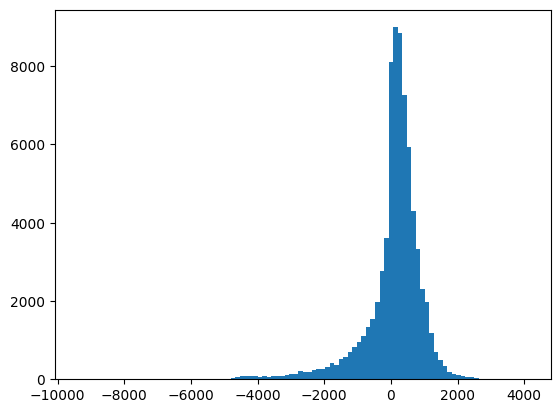

In [9]:
# quick histogram
all_values = [v for daily_values in daily_movements for v in daily_values[:-EXLUDE_LAST_N]]
plt.hist(all_values, bins=100)
plt.show()


<Axes: >

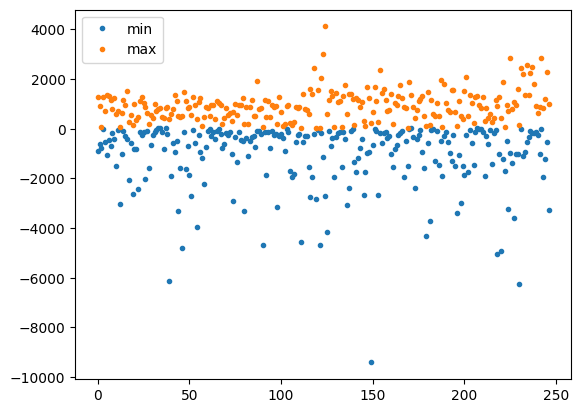

In [10]:
# daily min-max values

daily_min_max = [(min(daily_values[:-EXLUDE_LAST_N]), max(daily_values[:-EXLUDE_LAST_N])) for daily_values in daily_movements]
daily_min_max_df = pd.DataFrame(daily_min_max, columns=["min", "max"])

daily_min_max_df.plot(style='.')

In [11]:
n_days = daily_min_max_df.shape[0]

In [12]:
profit_categories = [np.inf, 2000, 1750, 1600, 1500, 1250, 1200, 1000, 800, 750, 500, 400, 300, 250, 150, 100, 50]
loss_categories = [-50, -100, -150, -250, -300, -400, -500, -750, -800, -1000, -1200, -1250, -1500, -1600, -1750, -2000, -2500, -3000, -4000, -5000, -np.inf]

profit_ratios = {
    cat: sum(
        1 if (daily_movement[:-EXLUDE_LAST_N] >= cat).any() else 0
        for daily_movement in daily_movements
    ) / n_days
    for cat in profit_categories
}

loss_ratios = {
    cat: sum(
        1 if (daily_movement[:-EXLUDE_LAST_N] <= cat).any() else 0
        for daily_movement in daily_movements
    ) / n_days
    for cat in loss_categories
}

profit_ratios, loss_ratios

({inf: 0.0,
  2000: 0.05668016194331984,
  1750: 0.08906882591093117,
  1600: 0.10121457489878542,
  1500: 0.13360323886639677,
  1250: 0.2591093117408907,
  1200: 0.27530364372469635,
  1000: 0.4008097165991903,
  800: 0.5991902834008097,
  750: 0.6194331983805668,
  500: 0.7651821862348178,
  400: 0.8340080971659919,
  300: 0.8582995951417004,
  250: 0.8785425101214575,
  150: 0.9271255060728745,
  100: 0.9554655870445344,
  50: 0.9878542510121457},
 {-50: 0.9149797570850202,
  -100: 0.8421052631578947,
  -150: 0.7692307692307693,
  -250: 0.680161943319838,
  -300: 0.631578947368421,
  -400: 0.582995951417004,
  -500: 0.5425101214574899,
  -750: 0.4331983805668016,
  -800: 0.41700404858299595,
  -1000: 0.3603238866396761,
  -1200: 0.30364372469635625,
  -1250: 0.29554655870445345,
  -1500: 0.2550607287449393,
  -1600: 0.22267206477732793,
  -1750: 0.19838056680161945,
  -2000: 0.14979757085020243,
  -2500: 0.12550607287449392,
  -3000: 0.08906882591093117,
  -4000: 0.0445344129554655

In [13]:
# profit vs loss matrix

profit_loss_matrix = pd.DataFrame(
    {
        profit_cat: [
            sum(
                1 \
                    if closing_strategy_limit_or_stoploss_after_n_or_last_m(
                        profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N
                    )(daily_movement) > 0 \
                    else 0
                for daily_movement in daily_movements
            ) / n_days
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

profit_loss_matrix

,inf,2000.0,1750.0,1600.0,1500.0,1250.0,1200.0,1000.0,800.0,750.0,500.0,400.0,300.0,250.0,150.0,100.0,50.0
-50.0,0.303644,0.303644,0.307692,0.307692,0.307692,0.323887,0.331984,0.348178,0.417004,0.433198,0.562753,0.655870,0.720648,0.761134,0.862348,0.910931,0.967611
-100.0,0.327935,0.327935,0.327935,0.327935,0.327935,0.344130,0.352227,0.368421,0.433198,0.449393,0.578947,0.672065,0.724696,0.761134,0.866397,0.914980,0.967611
-150.0,0.360324,0.360324,0.360324,0.360324,0.360324,0.376518,0.384615,0.404858,0.461538,0.473684,0.607287,0.692308,0.744939,0.777328,0.870445,0.914980,0.967611
-250.0,0.400810,0.400810,0.400810,0.400810,0.400810,0.417004,0.425101,0.441296,0.502024,0.514170,0.639676,0.724696,0.773279,0.797571,0.878543,0.919028,0.967611
-300.0,0.417004,0.417004,0.417004,0.417004,0.417004,0.433198,0.441296,0.457490,0.518219,0.530364,0.647773,0.728745,0.777328,0.801619,0.886640,0.927126,0.971660
-400.0,0.437247,0.437247,0.437247,0.437247,0.437247,0.453441,0.461538,0.481781,0.538462,0.550607,0.668016,0.736842,0.781377,0.805668,0.886640,0.927126,0.975709
-500.0,0.457490,0.457490,0.457490,0.457490,0.457490,0.469636,0.477733,0.497976,0.554656,0.562753,0.676113,0.740891,0.785425,0.809717,0.890688,0.927126,0.975709
-750.0,0.530364,0.530364,0.530364,0.530364,0.530364,0.542510,0.550607,0.566802,0.615385,0.623482,0.708502,0.773279,0.805668,0.825911,0.898785,0.931174,0.975709
-800.0,0.534413,0.534413,0.534413,0.534413,0.534413,0.546559,0.554656,0.570850,0.619433,0.627530,0.712551,0.773279,0.805668,0.825911,0.898785,0.935223,0.975709
-1000.0,0.570850,0.570850,0.570850,0.570850,0.570850,0.578947,0.582996,0.595142,0.639676,0.647773,0.728745,0.785425,0.813765,0.834008,0.902834,0.939271,0.975709


<Axes: title={'center': 'Win rates for strat waiting for 100 minutes before stoploss'}>

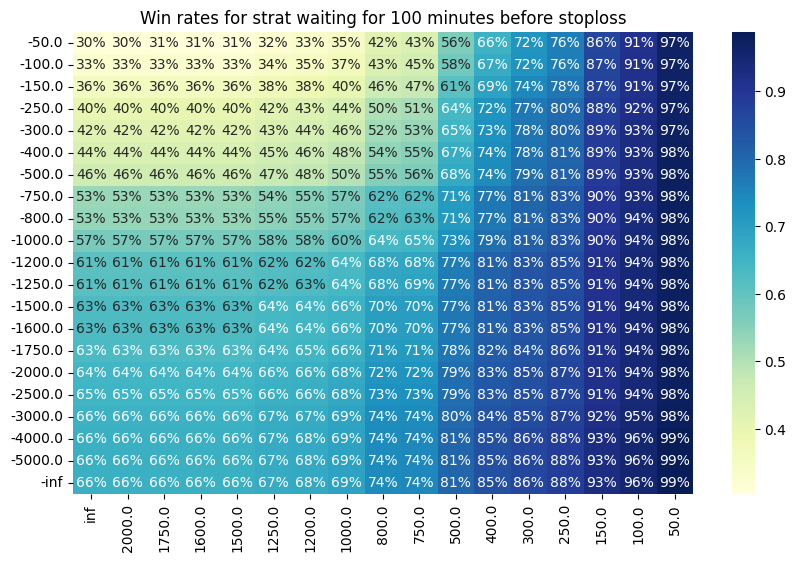

In [14]:
import seaborn as sns

# win rates

plt.figure(figsize=(10, 6))
plt.title(f"Win rates for strat waiting for {WAIT_FOR_N_BEFORE_STOPLOSS} minutes before stoploss")
sns.heatmap(profit_loss_matrix, annot=True, fmt=".0%", cmap="YlGnBu")

In [15]:
# profitable win rates according to Kelly criterion

kelly_profit_loss_matrix = pd.DataFrame(
    {
        profit_cat: [
            1 - abs(profit_cat / (profit_cat - loss_cat)) if not np.isinf(profit_cat) and not np.isinf(loss_cat) else np.nan
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

kelly_profit_loss_matrix

,inf,2000.0,1750.0,1600.0,1500.0,1250.0,1200.0,1000.0,800.0,750.0,500.0,400.0,300.0,250.0,150.0,100.0,50.0
-50.0,NaN,0.024390,0.027778,0.030303,0.032258,0.038462,0.040000,0.047619,0.058824,0.062500,0.090909,0.111111,0.142857,0.166667,0.250000,0.333333,0.500000
-100.0,NaN,0.047619,0.054054,0.058824,0.062500,0.074074,0.076923,0.090909,0.111111,0.117647,0.166667,0.200000,0.250000,0.285714,0.400000,0.500000,0.666667
-150.0,NaN,0.069767,0.078947,0.085714,0.090909,0.107143,0.111111,0.130435,0.157895,0.166667,0.230769,0.272727,0.333333,0.375000,0.500000,0.600000,0.750000
-250.0,NaN,0.111111,0.125000,0.135135,0.142857,0.166667,0.172414,0.200000,0.238095,0.250000,0.333333,0.384615,0.454545,0.500000,0.625000,0.714286,0.833333
-300.0,NaN,0.130435,0.146341,0.157895,0.166667,0.193548,0.200000,0.230769,0.272727,0.285714,0.375000,0.428571,0.500000,0.545455,0.666667,0.750000,0.857143
-400.0,NaN,0.166667,0.186047,0.200000,0.210526,0.242424,0.250000,0.285714,0.333333,0.347826,0.444444,0.500000,0.571429,0.615385,0.727273,0.800000,0.888889
-500.0,NaN,0.200000,0.222222,0.238095,0.250000,0.285714,0.294118,0.333333,0.384615,0.400000,0.500000,0.555556,0.625000,0.666667,0.769231,0.833333,0.909091
-750.0,NaN,0.272727,0.300000,0.319149,0.333333,0.375000,0.384615,0.428571,0.483871,0.500000,0.600000,0.652174,0.714286,0.750000,0.833333,0.882353,0.937500
-800.0,NaN,0.285714,0.313725,0.333333,0.347826,0.390244,0.400000,0.444444,0.500000,0.516129,0.615385,0.666667,0.727273,0.761905,0.842105,0.888889,0.941176
-1000.0,NaN,0.333333,0.363636,0.384615,0.400000,0.444444,0.454545,0.500000,0.555556,0.571429,0.666667,0.714286,0.769231,0.800000,0.869565,0.909091,0.952381


<Axes: title={'center': 'Difference between win rates and Kelly criterion threshold'}>

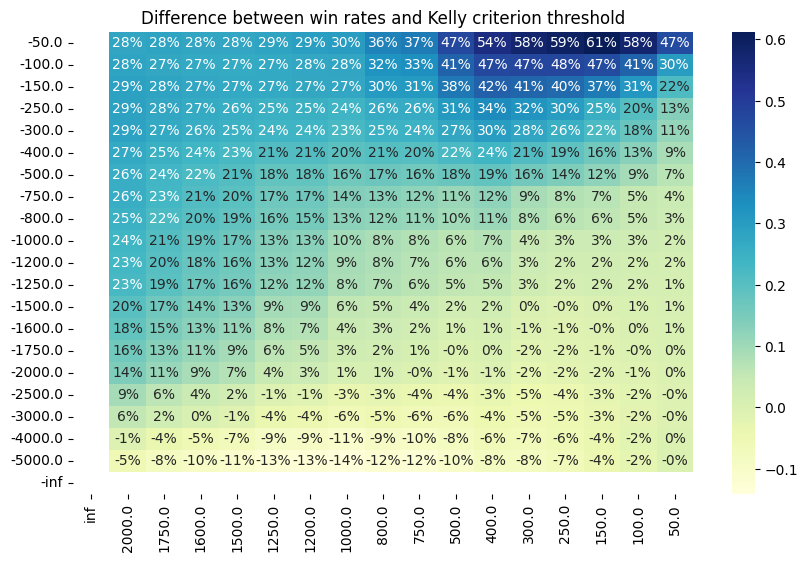

In [16]:
# difference between win rates and Kelly criterion

diff_profit_loss_matrix = profit_loss_matrix - kelly_profit_loss_matrix

plt.figure(figsize=(10, 6))
plt.title("Difference between win rates and Kelly criterion threshold")
sns.heatmap(diff_profit_loss_matrix, annot=True, fmt=".0%", cmap="YlGnBu")

<Axes: title={'center': 'Not reaching limit or stoploss'}>

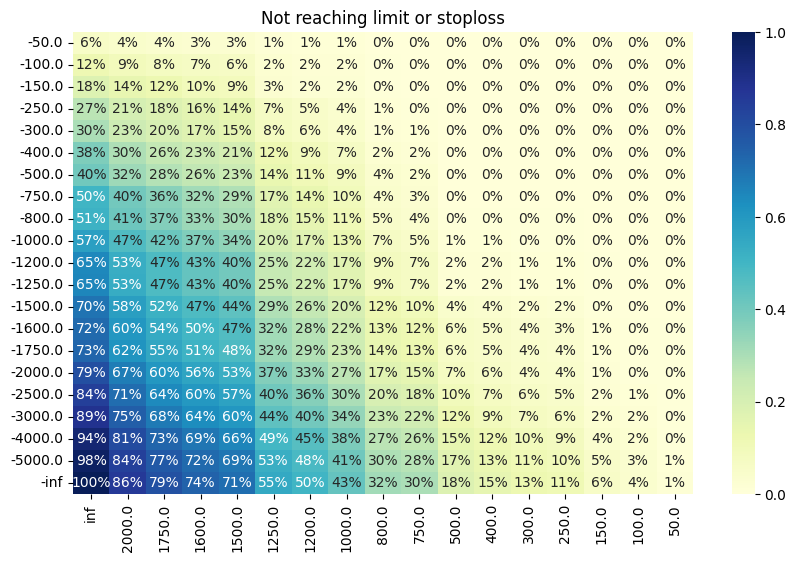

In [17]:
not_reaching_limit_or_stoploss_df = pd.DataFrame(
    {
        profit_cat: [
            sum(
                1 if ((daily_movement >= loss_cat).all() & (daily_movement <= profit_cat).all()) else 0
                for daily_movement in daily_movements
            ) / n_days
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(10, 6))
plt.title("Not reaching limit or stoploss")
sns.heatmap(not_reaching_limit_or_stoploss_df, annot=True, fmt=".0%", cmap="YlGnBu")

<Axes: title={'center': 'Total profit ($)'}>

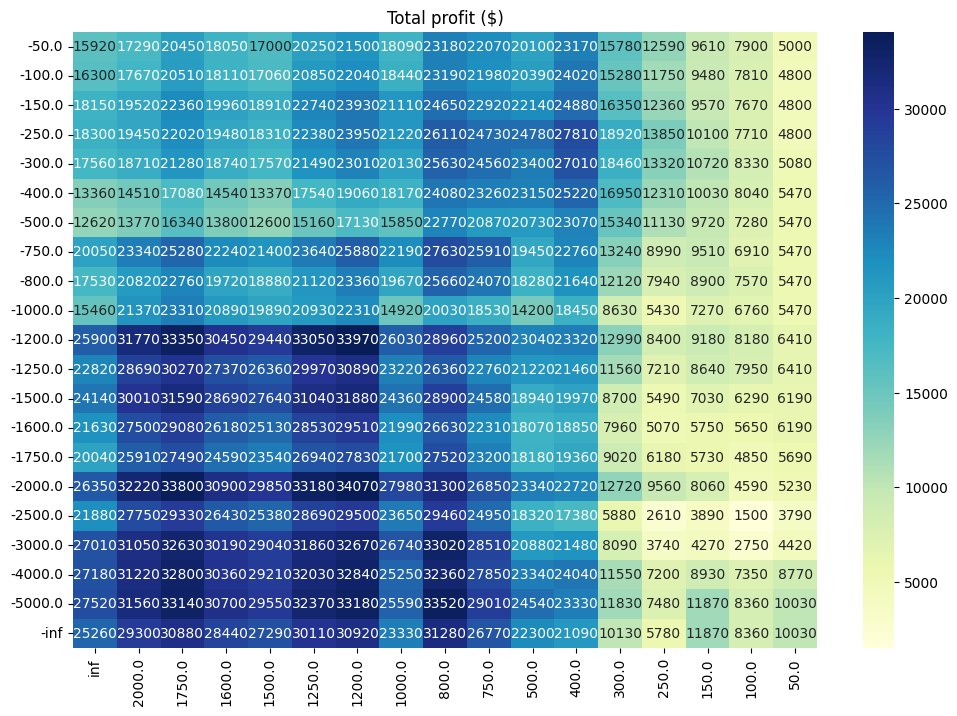

In [18]:
# total profit

total_profit_matrix = pd.DataFrame(
    {
        profit_cat: [
            sum(
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, 100, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            )
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Total profit ($)")
sns.heatmap(total_profit_matrix, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': 'Cumulative profit for strategy: 1750 limit w/o stop loss'}>

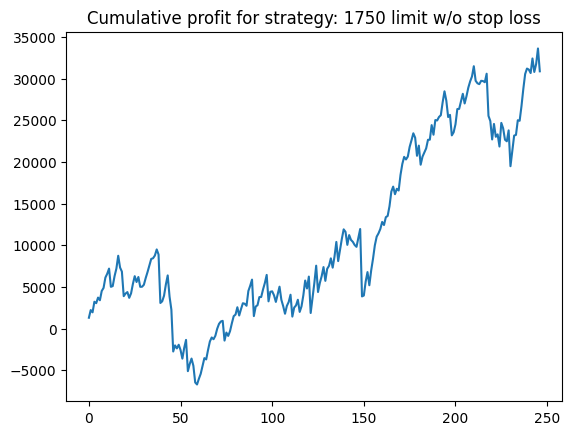

In [19]:
plt.title("Cumulative profit for strategy: 1750 limit w/o stop loss")
pnl = np.array([
    closing_strategy_limit_or_stoploss_after_n_or_last_m(1750, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
    for daily_movement in daily_movements
])
sns.lineplot(data=pnl.cumsum())

<Axes: title={'center': 'Cumulative profit for strategy: 400 limit w/ -400 stop loss'}>

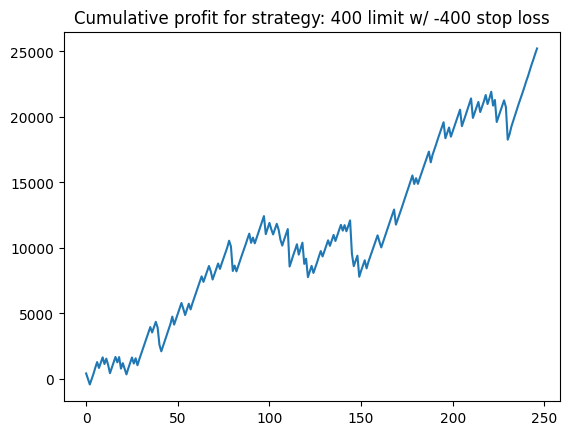

In [20]:
plt.title("Cumulative profit for strategy: 400 limit w/ -400 stop loss")
pnl = np.array([
    closing_strategy_limit_or_stoploss_after_n_or_last_m(
        400, -400, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
    for daily_movement in daily_movements
])
sns.lineplot(data=pnl.cumsum())

<Axes: title={'center': 'Cumulative profit for strategy: 150 limit w/o stop loss'}>

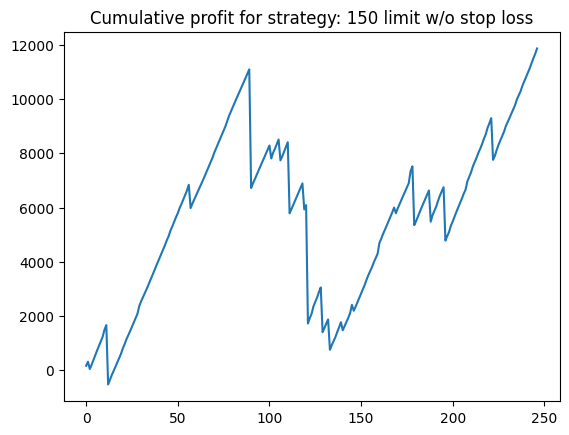

In [21]:
plt.title("Cumulative profit for strategy: 150 limit w/o stop loss")
pnl = np.array([
    closing_strategy_limit_or_stoploss_after_n_or_last_m(
        150, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
    for daily_movement in daily_movements
])
sns.lineplot(data=pnl.cumsum())

<Axes: title={'center': 'Cumulative profit for strategy: 50 limit w/o stop loss'}>

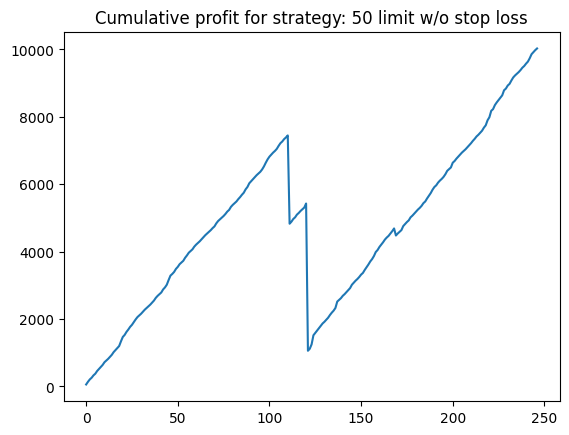

In [22]:
plt.title("Cumulative profit for strategy: 50 limit w/o stop loss")
pnl = np.array([
    closing_strategy_limit_or_stoploss_after_n_or_last_m(
        50, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
    for daily_movement in daily_movements
])
sns.lineplot(data=pnl.cumsum())

<Axes: title={'center': 'Biggest losing days ($)'}>

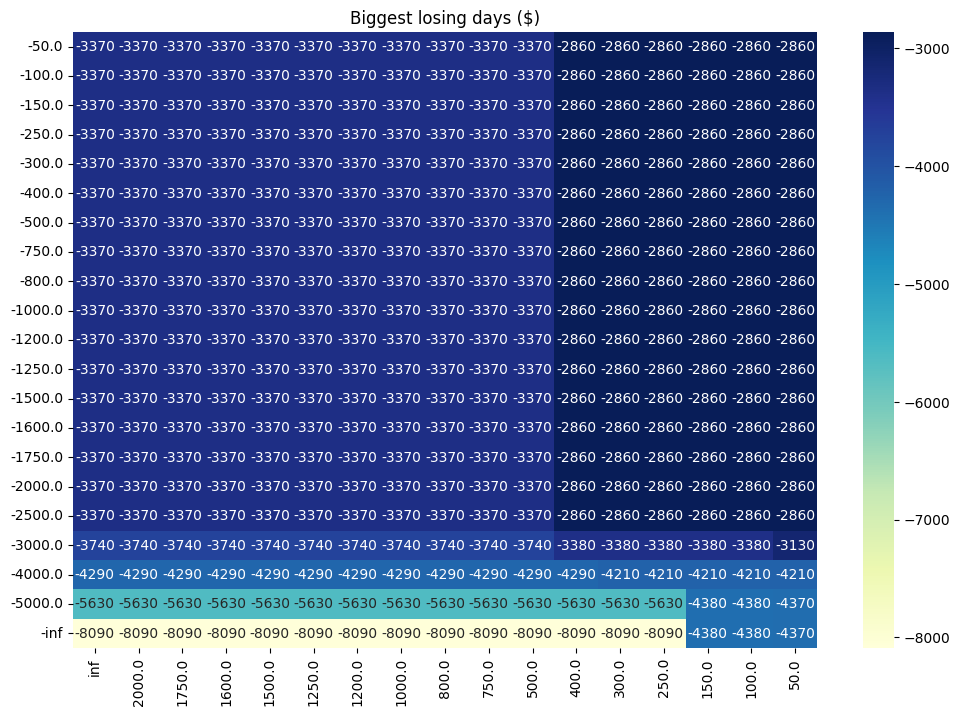

In [23]:
# biggest losing days

top_losers_df = pd.DataFrame(
    {
        profit_cat: [
            min(
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            )
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Biggest losing days ($)")
sns.heatmap(top_losers_df, annot=True, fmt=".0f", cmap="YlGnBu")

111


<Axes: title={'center': 'Worst Day for 400 / -400 w/ waiting for 100min before stoploss'}>

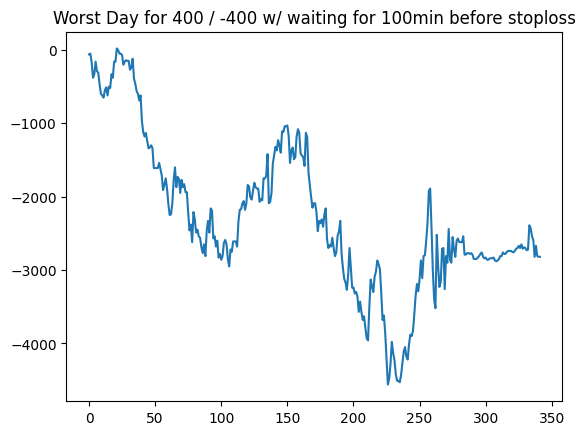

In [24]:
# hmm

daily_pnl = np.array([closing_strategy_limit_or_stoploss_after_n_or_last_m(400, 400, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement) for daily_movement in daily_movements])

plt.title(f"Worst Day for 400 / -400 w/ waiting for {WAIT_FOR_N_BEFORE_STOPLOSS}min before stoploss")
day_idx = np.argmin(daily_pnl)
print(day_idx)
sns.lineplot(daily_movements[day_idx])

173


<Axes: title={'center': 'Worst Day for 400 / -400 w/o waiting before stoploss'}>

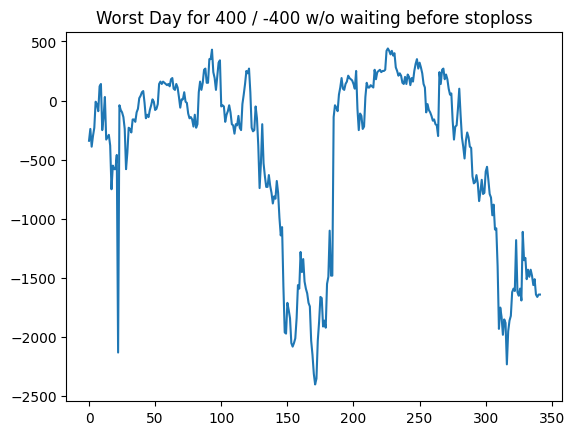

In [25]:
# hmm

daily_pnl = np.array([closing_strategy_limit_or_stoploss_after_n_or_last_m(400, 400, 0, EXLUDE_LAST_N)(daily_movement) for daily_movement in daily_movements])

plt.title("Worst Day for 400 / -400 w/o waiting before stoploss")
day_idx = np.argmin(daily_pnl)
print(day_idx)
sns.lineplot(daily_movements[day_idx])

Losing Days for 50 / -inf w/o waiting before stoploss (excluding last 30min)
day index 111


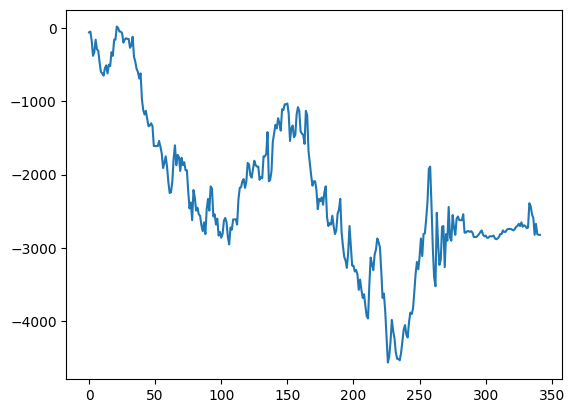

day index 121


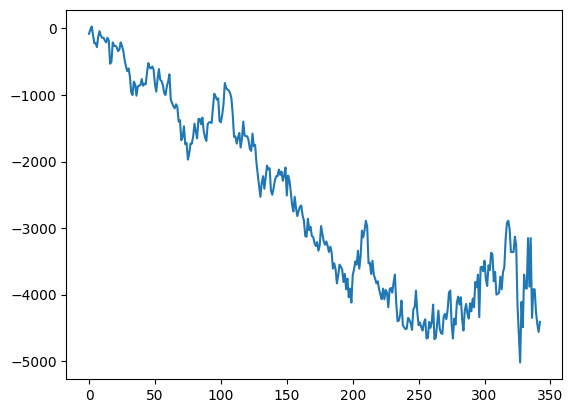

day index 169


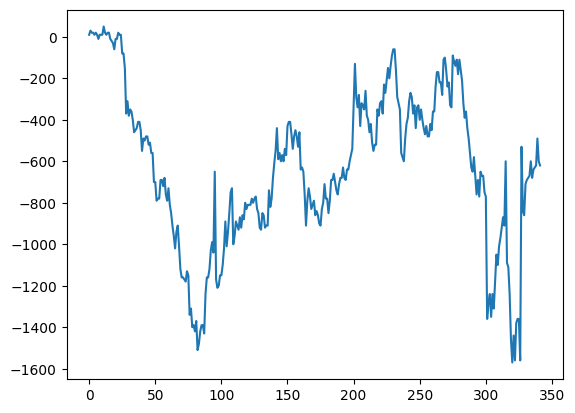

In [26]:
# hmm

daily_pnl = np.array([closing_strategy_limit_or_stoploss_after_n_or_last_m(50, -np.inf, 0, 30)(daily_movement) for daily_movement in daily_movements])

[losing_days_idxs] = np.where(daily_pnl < 0)

print("Losing Days for 50 / -inf w/o waiting before stoploss (excluding last 30min)")
for idx in losing_days_idxs:
    sns.lineplot(daily_movements[idx])
    print("day index", idx)
    plt.show()


In [27]:

# longest negative streak

def count_losing_streak_subarray(arr):
    curr_idx = 0
    total_loss = 0
    while curr_idx < len(arr) and arr[curr_idx] < 0:
        total_loss += arr[curr_idx]
        curr_idx += 1
    return curr_idx, total_loss 


def longest_losing_streak_loss(arr):
    _, longest_negative_streak_money = max(
        count_losing_streak_subarray(arr[i:])
        for i in range(len(arr))
    )
    return longest_negative_streak_money


def longest_losing_streak_days(arr):
    longest_negative_streak_days, _ = max(
        count_losing_streak_subarray(arr[i:])
        for i in range(len(arr))
    )
    return longest_negative_streak_days

def max_losing_streak(arr):
    return min(
        count_losing_streak_subarray(arr[i:])[1]
        for i in range(len(arr))
    )


longest_losing_streak_days(daily_pnl), longest_losing_streak_loss(daily_pnl), max_losing_streak(daily_pnl)

(1, -920.0000000000005, -3920.0)

<Axes: title={'center': "Longest losing streak (days) (don't wait until applying stoploss)"}>

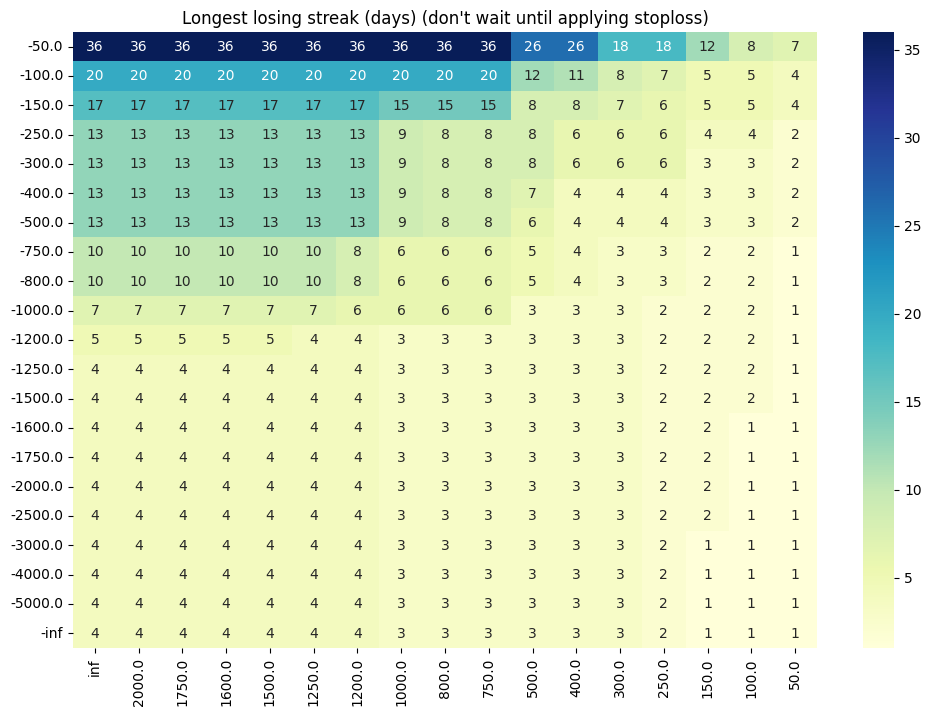

In [28]:
longest_losing_streak_days_df = pd.DataFrame(
    {
        profit_cat: [
            longest_losing_streak_days(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, 0, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Longest losing streak (days) (don't wait until applying stoploss)")
sns.heatmap(longest_losing_streak_days_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': "Longest losing streak ($)  (don't wait until applying stoploss)"}>

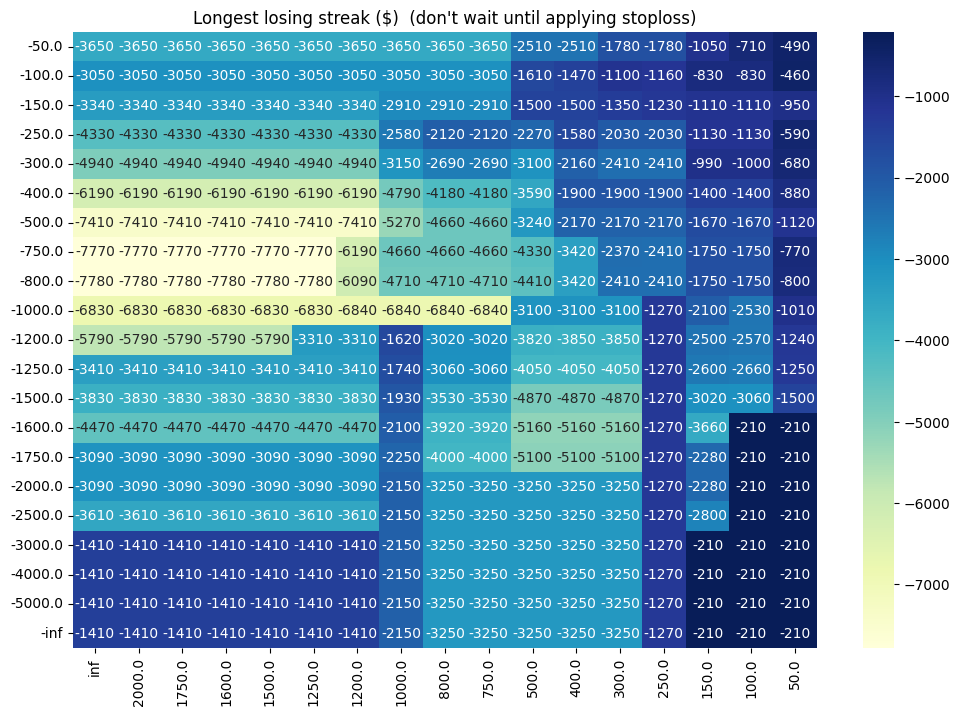

In [29]:
longest_losing_streak_loss_df = pd.DataFrame(
    {
        profit_cat: [
            longest_losing_streak_loss(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, 0, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Longest losing streak ($)  (don't wait until applying stoploss)")
sns.heatmap(longest_losing_streak_loss_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': "Worst losing streak ($)  (don't wait until applying stoploss)"}>

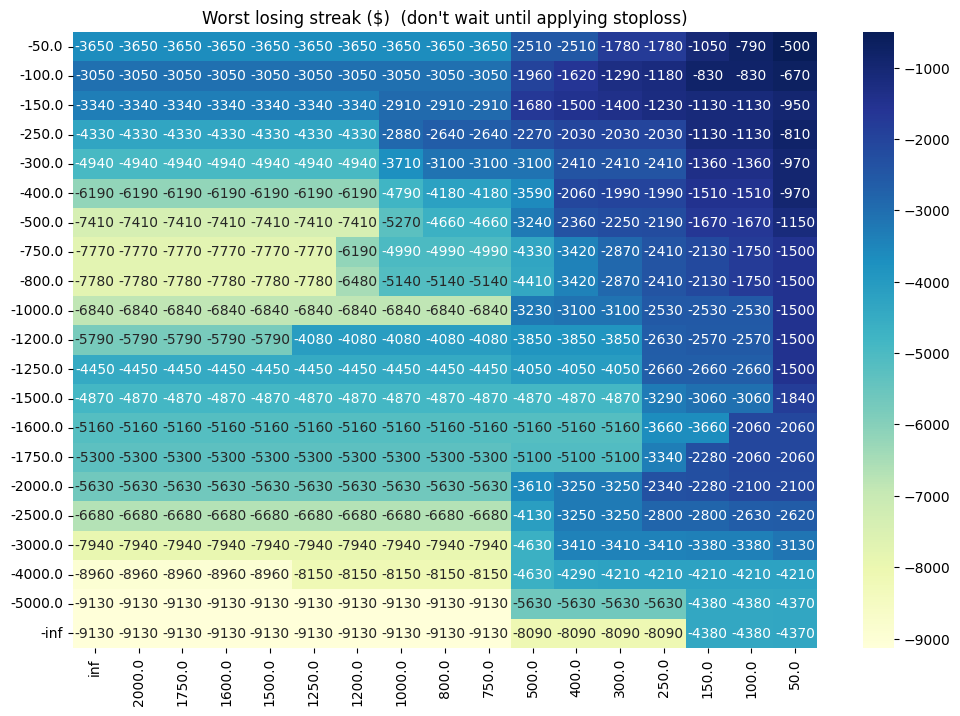

In [30]:
worst_losing_streak_loss_df = pd.DataFrame(
    {
        profit_cat: [
            max_losing_streak(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, 0, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title("Worst losing streak ($)  (don't wait until applying stoploss)")
sns.heatmap(worst_losing_streak_loss_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': 'Longest losing streak (days) (wait for 100min before applying stoploss)'}>

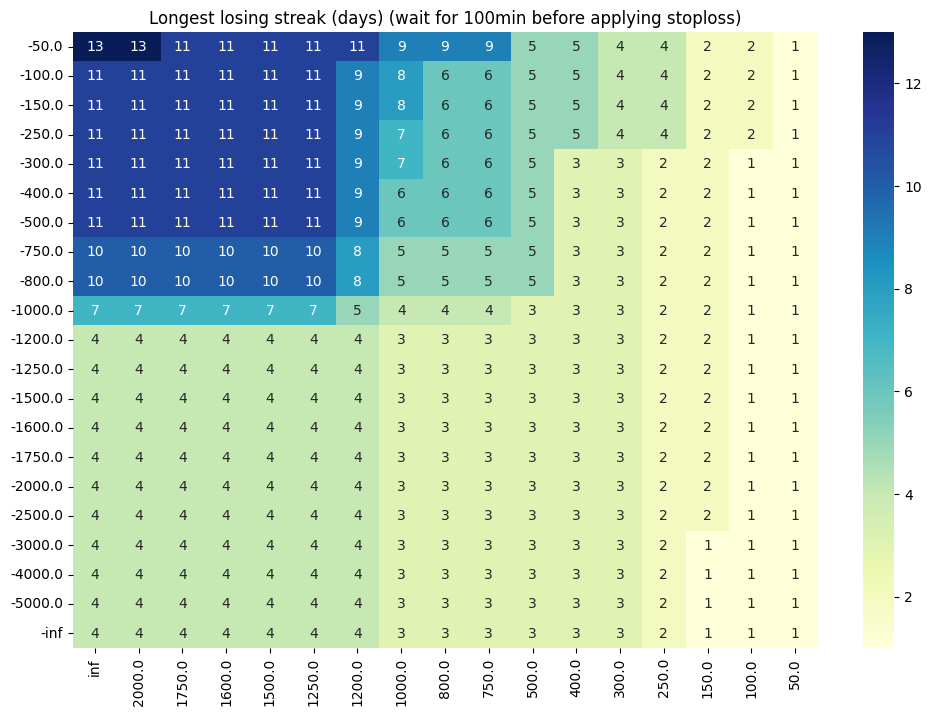

In [31]:
longest_losing_streak_days_df = pd.DataFrame(
    {
        profit_cat: [
            longest_losing_streak_days(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title(f"Longest losing streak (days) (wait for {WAIT_FOR_N_BEFORE_STOPLOSS}min before applying stoploss)")
sns.heatmap(longest_losing_streak_days_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': 'Longest losing streak ($) (wait for 100min before applying stoploss)'}>

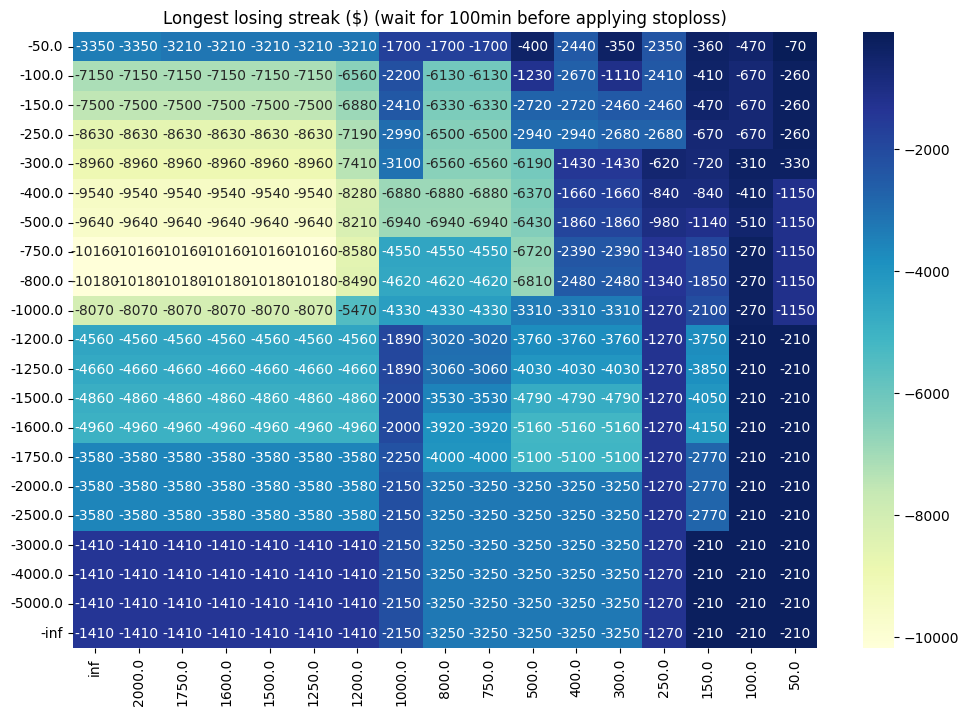

In [32]:
longest_losing_streak_loss_df = pd.DataFrame(
    {
        profit_cat: [
            longest_losing_streak_loss(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title(f"Longest losing streak ($) (wait for {WAIT_FOR_N_BEFORE_STOPLOSS}min before applying stoploss)")
sns.heatmap(longest_losing_streak_loss_df, annot=True, fmt=".0f", cmap="YlGnBu")

<Axes: title={'center': 'Worst losing streak ($) (wait for 100min before applying stoploss)'}>

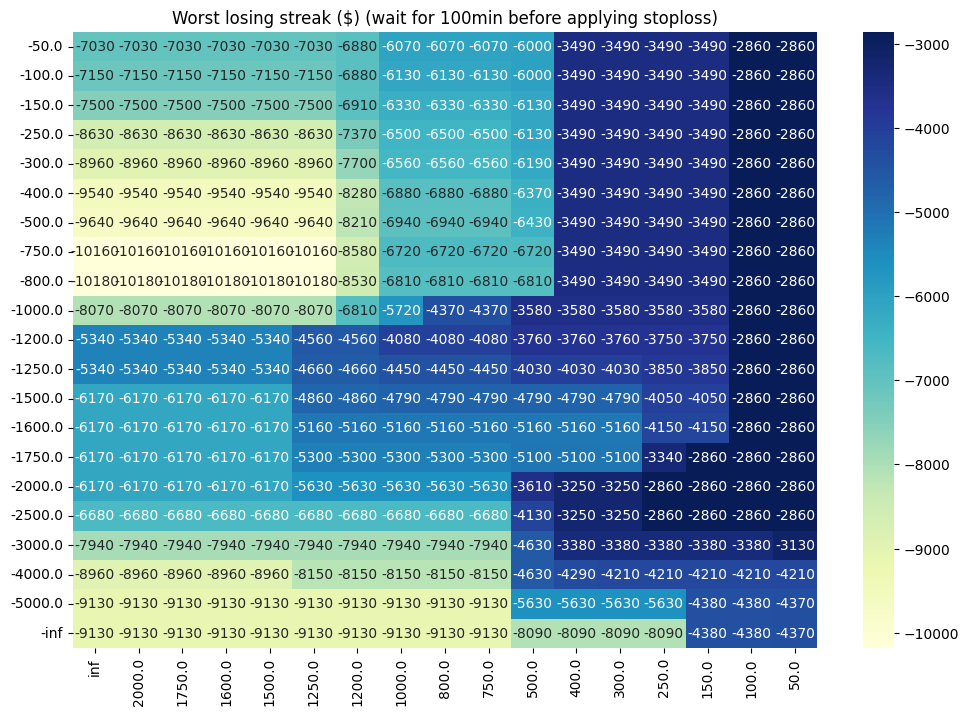

In [33]:
worst_losing_streak_loss_df = pd.DataFrame(
    {
        profit_cat: [
            max_losing_streak(np.array([
                closing_strategy_limit_or_stoploss_after_n_or_last_m(profit_cat, loss_cat, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)(daily_movement)
                for daily_movement in daily_movements
            ]))
            for loss_cat in loss_categories
        ]
        for profit_cat in profit_categories
    },
    index=loss_categories
)

plt.figure(figsize=(12, 8))
plt.title(f"Worst losing streak ($) (wait for {WAIT_FOR_N_BEFORE_STOPLOSS}min before applying stoploss)")
sns.heatmap(worst_losing_streak_loss_df, annot=True, fmt=".0f", cmap="YlGnBu")

In [34]:
def strategy_limit_reach_minute(arr, limit, stoploss, wait_n_before_stoploss, last_n):
    for idx, value in enumerate(arr[:-last_n]):
        if value >= limit:
            return idx
        if value <= stoploss and idx >= wait_n_before_stoploss:
            return -1
    return len(arr) - last_n

<Axes: title={'center': 'Minutes at which limit is reached: 400 limit w/ -400 stop loss'}, ylabel='Count'>

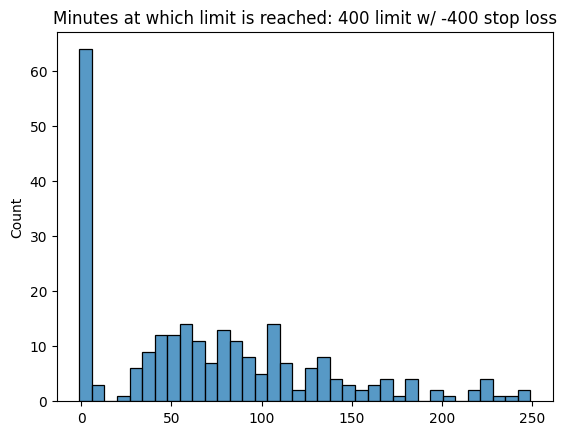

In [35]:
plt.title("Minutes at which limit is reached: 400 limit w/ -400 stop loss")

limit_400_reach_minute = np.array([
    strategy_limit_reach_minute(daily_movement, 400, -400, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)
    for daily_movement in daily_movements
])

sns.histplot(limit_400_reach_minute, bins=36)

<Axes: title={'center': 'Minutes at which limit is reached: 1750 limit w/o stop loss'}, ylabel='Count'>

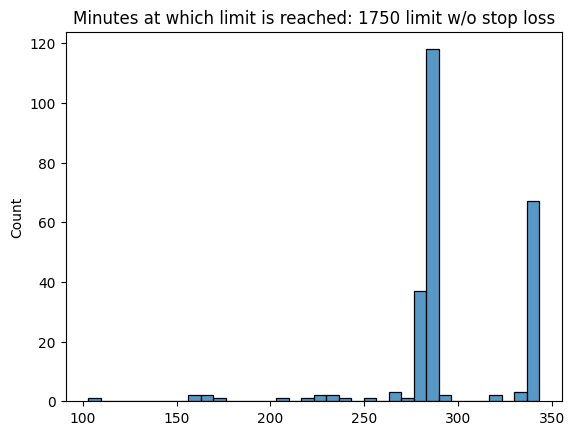

In [36]:
plt.title("Minutes at which limit is reached: 1750 limit w/o stop loss")

limit_1750_reach_minute = np.array([
    strategy_limit_reach_minute(daily_movement, 1750, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)
    for daily_movement in daily_movements
])

sns.histplot(limit_1750_reach_minute, bins=36)

<Axes: title={'center': 'Minutes at which limit is reached: 200 limit w/o stop loss'}, ylabel='Count'>

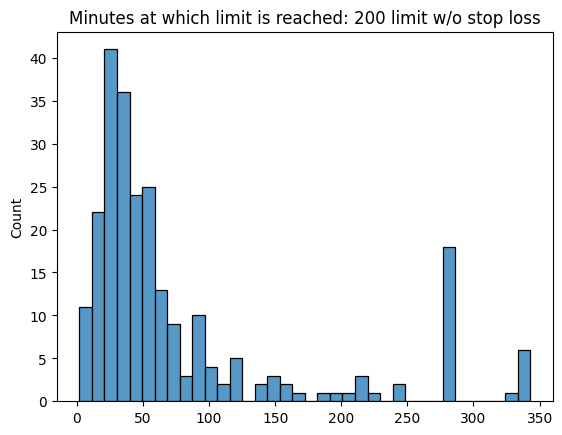

In [37]:
plt.title("Minutes at which limit is reached: 200 limit w/o stop loss")

limit_1750_reach_minute = np.array([
    strategy_limit_reach_minute(daily_movement, 200, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)
    for daily_movement in daily_movements
])

sns.histplot(limit_1750_reach_minute, bins=36)

<Axes: title={'center': 'Minutes at which limit is reached: 400 limit w/o stop loss'}, ylabel='Count'>

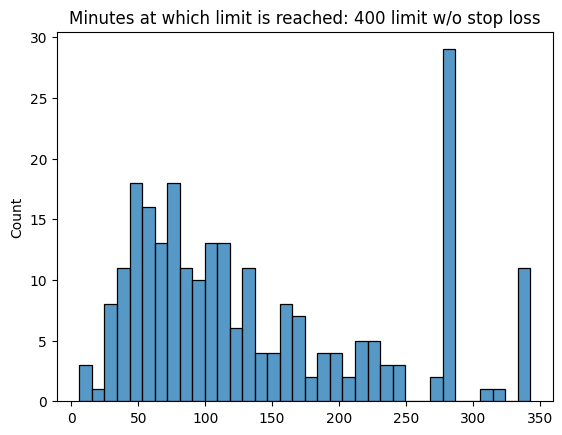

In [38]:
plt.title("Minutes at which limit is reached: 400 limit w/o stop loss")

limit_1750_reach_minute = np.array([
    strategy_limit_reach_minute(
        daily_movement, 400, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)
    for daily_movement in daily_movements
])

sns.histplot(limit_1750_reach_minute, bins=36)

<Axes: title={'center': 'Minutes at which limit is reached: 150 limit w/o stop loss'}, ylabel='Count'>

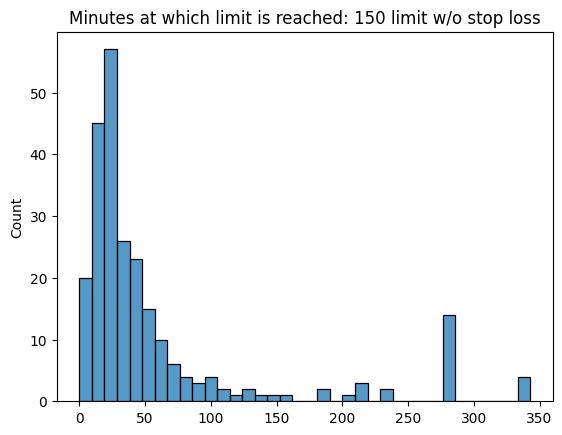

In [39]:
plt.title("Minutes at which limit is reached: 150 limit w/o stop loss")

limit_1750_reach_minute = np.array([
    strategy_limit_reach_minute(
        daily_movement, 150, -np.inf, WAIT_FOR_N_BEFORE_STOPLOSS, EXLUDE_LAST_N)
    for daily_movement in daily_movements
])

sns.histplot(limit_1750_reach_minute, bins=36)